In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random
from torch.nn.functional import pairwise_distance
from skorch.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from deap import base, creator, tools, algorithms
from torch.utils.data import TensorDataset, DataLoader


In [13]:

data_weather_encoded = pd.read_csv('data_weather_encoded.csv')

In [14]:
def create_lagged_features(df, window, target_column):
    lagged_df = df.copy()
    original_columns = df.columns.tolist()  # Get a list of all original columns

    # Create lagged features
    for i in range(1, window + 1):
        shifted_df = df.shift(i)
        shifted_df.columns = [f"{column}_lag{i}" for column in shifted_df.columns]
        lagged_df = pd.concat((lagged_df, shifted_df), axis=1)
    
    # Drop all current-day columns including the target column
    lagged_df.drop(columns=original_columns, inplace=True, errors='ignore')
    
    # Drop the first 'window' rows
    lagged_df = lagged_df.iloc[window:]
    return lagged_df




window = 20  
target_column = "mean_temp"  
data_weather_encoded_lagged = create_lagged_features(data_weather_encoded, window, target_column)
y = data_weather_encoded[target_column].iloc[window:]  
X = data_weather_encoded_lagged

split_index = int(0.8 * len(X))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]



In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))

#### 超参数优化-贝叶斯

In [5]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold, cross_val_score
class RBFNet(object):
    def __init__(self, hidden_layer=150, learning_rate=0.00005):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions

    # In order to be compatible with Scikit-learn, add get_params and set_params methods
    def get_params(self, deep=True):
        return {"hidden_layer": self.hidden_layer, "learning_rate": self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    
    
# Define a function for evaluating the model
def evaluate_model(hidden_layer, learning_rate):
    hidden_layer = int(hidden_layer)
    learning_rate = float(learning_rate)

    model = RBFNet(hidden_layer=hidden_layer, learning_rate=learning_rate)

    kf = KFold(n_splits=5)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)

    return np.mean(scores)

# Define the objective function
def objective(params):
    hidden_layer = int(params['hidden_layer'])
    learning_rate = float(params['learning_rate'])
    
    model = RBFNet(hidden_layer=hidden_layer, learning_rate=learning_rate)
    
    kf = KFold(n_splits=5)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)

    return {
        'loss': -np.mean(scores),  # hyperopt tries to minimize the 'loss'
        'status': STATUS_OK
    }

# Define the search space
space = {
    'hidden_layer': hp.quniform('hidden_layer', 50, 300, 1), 
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1))
}

# Optimization methods using hyperopt
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best Parameters: ", best)

100%|██████████| 50/50 [1:03:18<00:00, 75.98s/trial, best loss: 0.2212897472311152]
Best Parameters:  {'hidden_layer': 287.0, 'learning_rate': 1.8876051583893566e-05}


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Average MAE: 0.8844801428592476
Average MSE: 1.323748704069029
Average R^2: 0.958604075449759


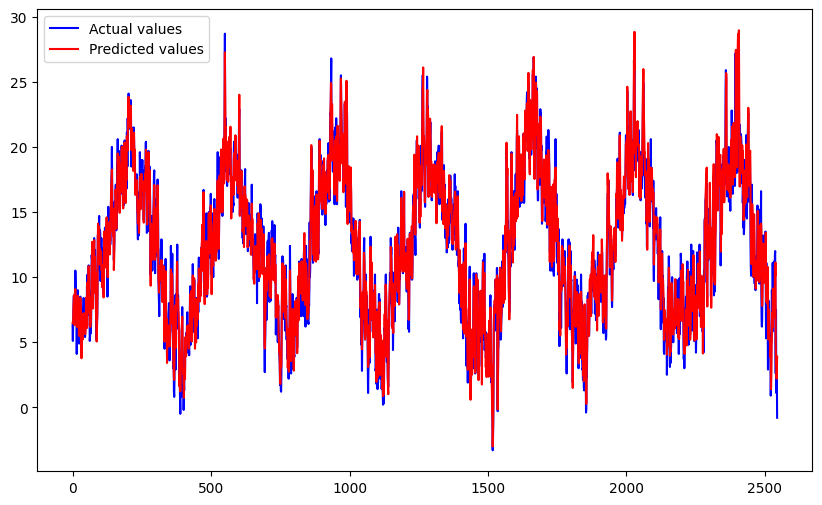

In [5]:
from sklearn.model_selection import TimeSeriesSplit

class RBFNet(object):
    def __init__(self, hidden_layer= 287, learning_rate=0.000019):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_absolute_error(y, y_pred) 

# normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to a numpy array to avoid indexing issues
y_np = y.to_numpy()

# Setup for time series 5-fold cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, r2_scores, mse_scores = [], [], []

for train_index, test_index in tscv.split(X):
    # Normalize the data inside the loop
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_index])
    X_test_fold = scaler.transform(X.iloc[test_index])

    
    y_train_fold, y_test_fold = y.to_numpy()[train_index], y.to_numpy()[test_index]

    # create and train the RBF network
    rbfnet = RBFNet()
    rbfnet.fit(X_train_fold, y_train_fold)

    # predict on test data
    y_test_pred = rbfnet.predict(X_test_fold)

    # collect the metrics
    mae_scores.append(mean_absolute_error(y_test_fold, y_test_pred))
    mse_scores.append(mean_squared_error(y_test_fold, y_test_pred))
    r2_scores.append(r2_score(y_test_fold, y_test_pred))

# Rest of your code remains unchanged...


# Calculate average scores after cross-validation
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f'Average MAE: {avg_mae}')
print(f'Average MSE: {avg_mse}')
print(f'Average R^2: {avg_r2}')

# Optional: If you want to visualize predictions for the last fold
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test_fold)), y_test_fold, color='blue', label='Actual values')
plt.plot(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted values')
plt.legend()
plt.show()

#### 超参数优化-遗传算法 

In [15]:
# Use the GPU if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train_scaled).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test_scaled).float().to(device)

In [7]:
import torch.nn as nn
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["OMP_NUM_THREADS"] = "4"

class RBFLayer(nn.Module):
    def __init__(self, input_dim, hidden_layer, centers, learning_rate=0.000019):
        super(RBFLayer, self).__init__()
        self.learning_rate = learning_rate
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.out_weights = nn.Parameter(torch.randn(hidden_layer, 1))

    def forward(self, x):
        size = (x.size(0), self.centers.size(0))
        G = torch.empty(size, device=device)
        for i in range(self.centers.size(0)):
            G[:, i] = torch.exp(-self.learning_rate * (x - self.centers[i]).pow(2).sum(1))
        output = G @ self.out_weights
        return output

class RBFNet(nn.Module):
    def __init__(self, input_dim, hidden_layer):
        super(RBFNet, self).__init__()
        self.scaler = StandardScaler()
        dummy_data = np.random.rand(1000, input_dim)
        scaled_dummy = self.scaler.fit_transform(dummy_data)
        kmeans = KMeans(n_clusters=hidden_layer, n_init=10, random_state=0).fit(scaled_dummy)
        centers = kmeans.cluster_centers_
        self.rbf = RBFLayer(input_dim, hidden_layer, centers).to(device)

    def forward(self, x):
        return self.rbf(x)

    def fit(self, X_np, y_np):
        X_np = np.array(X_np)
        y_np = np.array(y_np).reshape(-1, 1)
        X_np = self.scaler.transform(X_np)
        X = torch.tensor(X_np, dtype=torch.float32).to(device)
        y = torch.tensor(y_np, dtype=torch.float32).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = self.forward(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

    def predict(self, X_np):
        X_np = np.array(X_np)
        X_np = self.scaler.transform(X_np)
        X = torch.tensor(X_np, dtype=torch.float32).to(device)
        with torch.no_grad():
            predictions = self.forward(X)
        return predictions.cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return -np.mean(np.abs(y - y_pred))



In [ ]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_absolute_error
import random
import torch

# Define the fitness function
def fitness(individual):
    hidden_layer, lr = int(individual[0]), individual[1]
    
    # Check and correct the hidden_layer value
    if hidden_layer < 5:  # Here 5 is the minimum allowed value, but you can adjust as needed
        hidden_layer = 5
    
    rbf_net = RBFNet(input_dim=X_train.shape[1], hidden_layer=hidden_layer)
    rbf_net.fit(X_train, y_train)
    y_pred = rbf_net.predict(X_test)
    error = mean_absolute_error(y_test, y_pred)
    return error,



# Define the parts of the genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("hidden_layer", random.randint, 5, 500)
toolbox.register("lr", random.uniform, 0.00001, 0.1)

# Structure initializers
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.hidden_layer, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operator registering
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=[20, 0.05], sigma=[5, 0.02], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algorithm parameters
population_size = 50
crossover_prob = 0.5
mutation_prob = 0.2
num_generations = 30

pop = toolbox.population(n=population_size)

# Results holder
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, crossover_prob, mutation_prob, num_generations, stats=stats, halloffame=hof, verbose=True)

# Print the best individual
print("Best individual:", hof[0], "Fitness:", hof[0].fitness.values[0])


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Average MAE: 0.8770187732909542, Average MSE: 1.3016950383849109, Average R^2 Score: 0.9592925623930972


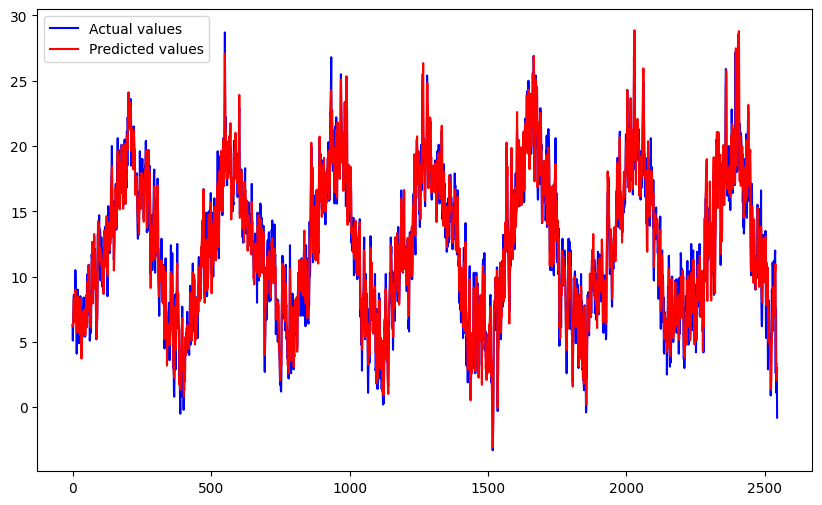

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class RBFNet(object):
    def __init__(self, hidden_layer=295, learning_rate=0.00001):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_absolute_error(y, y_pred) 

# normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to a numpy array to avoid indexing issues
y_np = y.to_numpy()

# Setup for time series 5-fold cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, r2_scores, mse_scores = [], [], []

for train_index, test_index in tscv.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

    # create and train the RBF network
    rbfnet = RBFNet()
    rbfnet.fit(X_train_fold, y_train_fold)

    # predict on test data
    y_test_pred = rbfnet.predict(X_test_fold)

    # collect the metrics
    mae_scores.append(mean_absolute_error(y_test_fold, y_test_pred))
    mse_scores.append(mean_squared_error(y_test_fold, y_test_pred))
    r2_scores.append(r2_score(y_test_fold, y_test_pred))


# Display average results
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average MAE: {avg_mae}, Average MSE: {avg_mse}, Average R^2 Score: {avg_r2}")

# Plotting the results from the last fold as an example
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test_fold)), y_test_fold, color='blue', label='Actual values')
plt.plot(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted values')
plt.legend()
plt.show()

In [7]:
#Bayesian optimization works better, using Bayesian hyperparameters

##### 单层RBFNN模型特征重要性

In [11]:
from sklearn.inspection import permutation_importance

# Compute permutation importances
result = permutation_importance(rbfnet, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create a dictionary for storing the summed feature importance
feature_importances = {col: 0 for col in ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
                                          'min_temp', 'precipitation', 'pressure', 'snow_depth', 'year', 'day',
                                          'weekday', 'quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4']}

# Add the importance to the original feature
for i in range(X.columns.shape[0]):
    feature = X.columns[i]
    original_feature = feature.split('_lag')[0]  # remove the lag part
    feature_importances[original_feature] += result.importances_mean[i]

# Sort features by importance
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print out feature importances
for feature, importance in sorted_importances:
    print(f'{feature}: {importance}')


max_temp: 3.0842044418654426
min_temp: 2.9316616249701246
weekday: 0.5714544350537322
global_radiation: 0.5210038640018756
quarter_Q1: 0.2716329421743759
quarter_Q2: 0.2553834803646668
sunshine: 0.24597275806366323
quarter_Q4: 0.2099502406415379
mean_temp: 0.18751031526811363
quarter_Q3: 0.14299418411927137
pressure: 0.13507989281919788
year: 0.027522207111702324
cloud_cover: 0.017434843124873006
day: 0.008839773119503761
snow_depth: 0.006968550416236462
precipitation: 7.98678848327407e-05


#### 双层RBFNN模型

##### 超参数优化

In [8]:
import pyswarms as ps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

class RBFNet(object):
    def __init__(self, hidden_layer=100, learning_rate=0.005520979515293883):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        # Check if X is 1-D, if so, reshape to 2-D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)

        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        # Check if X is 1-D, if so, reshape to 2-D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)

        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions

    def get_params(self, deep=True):
        return {"hidden_layer": self.hidden_layer, "learning_rate": self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


class MultiLayerRBFNet(object):
    def __init__(self, first_layer=100, second_layer=50, learning_rate=0.005520979515293883):
        self.first_layer = first_layer
        self.second_layer = second_layer
        self.learning_rate = learning_rate
        self.first_rbf = RBFNet(hidden_layer=first_layer, learning_rate=learning_rate)
        self.second_rbf = RBFNet(hidden_layer=second_layer, learning_rate=learning_rate)
        self.scaler = StandardScaler()

    def fit(self, X, y):
        X_train_scaled = self.scaler.fit_transform(X)
        self.first_rbf.fit(X_train_scaled, y)
        first_layer_predictions = self.first_rbf.predict(X_train_scaled)
        self.second_rbf.fit(first_layer_predictions, y)

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        first_layer_predictions = self.first_rbf.predict(X_scaled)
        second_layer_predictions = self.second_rbf.predict(first_layer_predictions)
        return second_layer_predictions

    def get_params(self, deep=True):
        return {"first_layer": self.first_layer, "second_layer": self.second_layer, "learning_rate": self.learning_rate}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


import optuna

def objective(trial):
    first_layer = trial.suggest_int('first_layer', 50, 250)
    second_layer = trial.suggest_int('second_layer', 50, 150)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)

    ml_rbfnet = MultiLayerRBFNet(first_layer=first_layer, second_layer=second_layer, learning_rate=learning_rate)
    ml_rbfnet.fit(X_train, y_train)
    y_test_pred = ml_rbfnet.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    return mae  # return an objective value to be minimized

study = optuna.create_study()  # create a study object
study.optimize(objective, n_trials=100)  # perform optimization

print("Best Parameters: ", study.best_params)  # output best parameters


D:\Anaconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-08-12 09:06:29,250] A new study created in memory with name: no-name-ed62d44d-282e-48d8-8a46-683779d7edf6
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anac

[I 2023-08-12 09:14:18,276] Trial 6 finished with value: 1.2708864894011314 and parameters: {'first_layer': 61, 'second_layer': 71, 'learning_rate': 2.1884218027657424e-05}. Best is trial 1 with value: 0.3928415398039068.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 09:23:24,198] Trial 14 finished with value: 0.8709056412245451 and parameters: {'first_layer': 137, 'second_layer': 90, 'learning_rate': 9.916849236382164e-05}. Best is trial 1 with value: 0.3928415398039068.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'a

C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 09:33:45,107] Trial 22 finished with value: 0.5746685566782459 and parameters: {

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 09:43:34,072] Trial 29 finished with value: 0.977133817413974 and parameters: {'first_layer': 222, 'second_layer': 101, 'learning_rate': 0.0008404675529520976}. Best is trial 1 with value: 0.3928415398039068.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'a

[I 2023-08-12 09:53:41,560] Trial 36 finished with value: 0.4849244557040793 and parameters: {'first_layer': 216, 'second_layer': 83, 'learning_rate': 2.4122500113962084e-05}. Best is trial 1 with value: 0.3928415398039068.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to '

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 10:04:43,438] Trial 44 finished with value: 0.38347353909753396 and parameters: {'first_layer': 242, 'second_layer': 123, 'learning_rate': 1.8560427733184387e-05}. Best is trial 44 with value: 0.38347353909753396.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 

[I 2023-08-12 10:14:23,357] Trial 51 finished with value: 0.40828504913608 and parameters: {'first_layer': 250, 'second_layer': 131, 'learning_rate': 1.5179133449106113e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 10:26:05,478] Trial 59 finished with value: 0.4502820686578222 and parameters: {'first_layer': 240, 'second_layer': 140, 'learning_rate': 3.5329226254652065e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 t

[I 2023-08-12 10:36:46,047] Trial 66 finished with value: 0.45501434754247705 and parameters: {'first_layer': 228, 'second_layer': 150, 'learning_rate': 1.4028127539413865e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 10:48:59,406] Trial 74 finished with value: 0.40683016862766025 and parameters: {'first_layer': 230, 'second_layer': 148, 'learning_rate': 1.983364810925501e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 t

[I 2023-08-12 10:59:13,842] Trial 81 finished with value: 0.3757064422767051 and parameters: {'first_layer': 229, 'second_layer': 53, 'learning_rate': 1.0009795594926115e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[I 2023-08-12 11:07:03,789] Trial 89 finished with value: 0.44529583265309647 and parameters: {'first_layer': 239, 'second_layer': 124, 'learning_rate': 2.449554124253532e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 t

[I 2023-08-12 11:11:50,770] Trial 96 finished with value: 0.5325082733687093 and parameters: {'first_layer': 222, 'second_layer': 136, 'learning_rate': 4.099152357919051e-05}. Best is trial 50 with value: 0.37411394881403864.
C:\Users\95420\AppData\Local\Temp\ipykernel_20756\1499400744.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

Best Parameters:  {'first_layer': 242, 'second_layer': 123, 'learning_rate': 1.535559652239131e-05}


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

Average MAE: 0.8677864204835453, Average MSE: 1.2520392063767685, Average R^2 Score: 0.9608357307190246


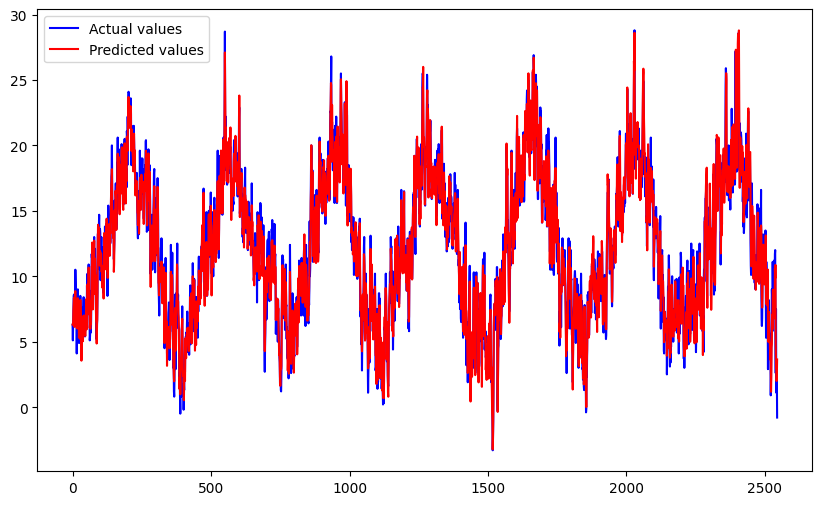

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class RBFNet(object):
    def __init__(self, hidden_layer=242, learning_rate=0.0000153556):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions

class MultiLayerRBFNet(object):
    def __init__(self, first_layer=242, second_layer=123, learning_rate=0.000015):
        self.first_layer = first_layer
        self.second_layer = second_layer
        self.learning_rate = learning_rate
        self.first_rbf = RBFNet(hidden_layer=first_layer, learning_rate=learning_rate)
        self.second_rbf = RBFNet(hidden_layer=second_layer, learning_rate=learning_rate)
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # fit the first layer
        X_train_scaled = self.scaler.fit_transform(X)
        self.first_rbf.fit(X_train_scaled, y)

        # use the predictions of the first layer as input to the second layer
        first_layer_predictions = self.first_rbf.predict(X_train_scaled)

        # fit the second layer
        self.second_rbf.fit(first_layer_predictions, y)

    def predict(self, X):
        # normalize inputs
        X_scaled = self.scaler.transform(X)

        # obtain the first layer's predictions
        first_layer_predictions = self.first_rbf.predict(X_scaled)

        # use the first layer's predictions as input to the second layer
        second_layer_predictions = self.second_rbf.predict(first_layer_predictions)

        return second_layer_predictions




# normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to a numpy array to avoid indexing issues
y_np = y.to_numpy()

# Setup for time series 5-fold cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, r2_scores, mse_scores = [], [], []

for train_index, test_index in tscv.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

    # create and train the multi-layer RBF network
    ml_rbfnet = MultiLayerRBFNet(first_layer=247, second_layer=124)
    ml_rbfnet.fit(X_train,y_train_scaled)

    # predict on test data
    y_test_pred = rbfnet.predict(X_test_fold)

    # collect the metrics
    mae_scores.append(mean_absolute_error(y_test_fold, y_test_pred))
    mse_scores.append(mean_squared_error(y_test_fold, y_test_pred))
    r2_scores.append(r2_score(y_test_fold, y_test_pred))


# Display average results
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print(f"Average MAE: {avg_mae}, Average MSE: {avg_mse}, Average R^2 Score: {avg_r2}")

# Plotting the results from the last fold as an example
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test_fold)), y_test_fold, color='blue', label='Actual values')
plt.plot(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted values')
plt.legend()
plt.show()



In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# define the number of splits for the cross-validation
n_splits = 5

# create the KFold object
tscv = TimeSeriesSplit(n_splits=n_splits)

# create the models
rbfnet = RBFNet()
ml_rbfnet = MultiLayerRBFNet(first_layer=247, second_layer=124)

# initialize lists to hold the performance metrics
mse_single = []
rmse_single = []
mae_single = []
r2_single = []

mse_multi = []
rmse_multi = []
mae_multi = []
r2_multi = []

# perform k-fold cross-validation
for train_index, test_index in tscv.split(X):
    # get the training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    # normalize inputs
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))
    # train and predict using the single-layer model
    rbfnet.fit(X_train_scaled, y_train)
    y_test_pred_single = rbfnet.predict(X_test_scaled)

    # train and predict using the multi-layer model
    ml_rbfnet.fit(X_train_scaled, y_train_scaled)
    y_test_pred_multi = ml_rbfnet.predict(X_test)

    # calculate and store performance metrics for the single-layer model
    mse_single.append(mean_squared_error(y_test, y_test_pred_single))
    rmse_single.append(sqrt(mse_single[-1]))
    mae_single.append(mean_absolute_error(y_test, y_test_pred_single))
    r2_single.append(r2_score(y_test, y_test_pred_single))

    # calculate and store performance metrics for the multi-layer model
    mse_multi.append(mean_squared_error(y_test_scaled, y_test_pred_multi))
    rmse_multi.append(sqrt(mse_multi[-1]))
    mae_multi.append(mean_absolute_error(y_test_scaled, y_test_pred_multi))
    r2_multi.append(r2_score(y_test_scaled, y_test_pred_multi))

# print the average results
print(f"Single-layer model: MSE={np.mean(mse_single)}, RMSE={np.mean(rmse_single)}, MAE={np.mean(mae_single)}, R2={np.mean(r2_single)}")
print(f"Multi-layer model: MSE={np.mean(mse_multi)}, RMSE={np.mean(rmse_multi)}, MAE={np.mean(mae_multi)}, R2={np.mean(r2_multi)}")


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Win

Single-layer model: MSE=0.3426634572879047, RMSE=0.5635919112614373, MAE=0.39513891019429226, R2=0.9893005597666218
Multi-layer model: MSE=0.021205772371834936, RMSE=0.13908600982097533, MAE=0.11508629351197994, R2=0.9787942276281649


##### 比对两个模型对不同periods的预测精度

##### 单层模型

In [5]:
class RBFNet(object):
    def __init__(self, hidden_layer=295, learning_rate=0.00001):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        # The shape of X is [n_samples, n_features], and the shape of y is [n_samples, period]
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights  # The shape of the predicted values here should be [n_samples, period]
        return predictions

    def score(self, X, y):
        y_pred = self.predict(X)
        # Compute the mean of the mean absolute error at each output time step
        return -np.mean([mean_absolute_error(y[:, i], y_pred[:, i]) for i in range(y.shape[1])])

In [15]:
# Define the periods for forecasting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
periods = [1, 3, 7, 14]
window_size = 20

models = {}

for period in periods:
    print(f"Training model for a forecast period of {period} days...")

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    mse_list = []
    mae_list = []
    r2_list = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        # Adjust the y values to consider multiple days prediction
        y_train_multi = []
        y_test_multi = []
        for i in range(len(X_train) - period):
            y_train_multi.append(y.iloc[train_index[i]:train_index[i] + period].values)
        for i in range(len(X_test) - period):
            y_test_multi.append(y.iloc[test_index[i]:test_index[i] + period].values)
        
        y_train_multi = np.array(y_train_multi)
        y_test_multi = np.array(y_test_multi)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        mlp = RBFNet()

        mlp.fit(X_train_scaled[:-period], y_train_multi)  # Exclude the last 'period' number of data

        predictions = mlp.predict(X_test_scaled[:-period])

        mse = mean_squared_error(y_test_multi, predictions)
        mae = mean_absolute_error(y_test_multi, predictions)
        r2 = r2_score(y_test_multi, predictions)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

    # Use the mean values of the metrics for displaying
    print(f"Period: {period} days, MSE: {np.mean(mse_list)}, MAE: {np.mean(mae_list)}, R^2: {np.mean(r2_list)}")

    models[period] = mlp




Training model for a forecast period of 1 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Period: 1 days, MSE: 1.3083227899698582, MAE: 0.8806171838597718, R^2: 0.959078554367264
Training model for a forecast period of 3 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Period: 3 days, MSE: 3.6496200060190676, MAE: 1.4521199484396763, R^2: 0.8858029932886712
Training model for a forecast period of 7 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Period: 7 days, MSE: 6.320853878673427, MAE: 1.941578837888305, R^2: 0.8021469483774478
Training model for a forecast period of 14 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change 

Period: 14 days, MSE: 7.8583288352783685, MAE: 2.1946902450325694, R^2: 0.7539315113456364


##### 双层

In [5]:
class RBFNet(object):
    def __init__(self, hidden_layer=242, learning_rate=0.000015):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.centers = None
        self.weights = None
        self.scaler = StandardScaler()

    def _kernel_function(self, center, data_point):
        return np.exp(-self.learning_rate * np.sum((center - data_point) ** 2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((len(X), self.hidden_layer))
        for data_point_arg, data_point in enumerate(X):
            for center_arg, center in enumerate(self.centers):
                G[data_point_arg, center_arg] = self._kernel_function(center, data_point)
        return G

    def fit(self, X, y):
        self.centers = KMeans(n_clusters=self.hidden_layer, random_state=0).fit(X).cluster_centers_
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G.T @ G) @ G.T @ y

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        predictions = G @ self.weights
        return predictions

class MultiLayerRBFNet(object):
    def __init__(self, first_layer=242, second_layer=124, learning_rate=0.000013):
        self.first_layer = first_layer
        self.second_layer = second_layer
        self.learning_rate = learning_rate
        self.first_rbf = RBFNet(hidden_layer=first_layer, learning_rate=learning_rate)
        self.second_rbf = RBFNet(hidden_layer=second_layer, learning_rate=learning_rate)
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # fit the first layer
        X_train_scaled = self.scaler.fit_transform(X)
        self.first_rbf.fit(X_train_scaled, y)

        # use the predictions of the first layer as input to the second layer
        first_layer_predictions = self.first_rbf.predict(X_train_scaled)

        # fit the second layer
        self.second_rbf.fit(first_layer_predictions, y)


    def predict(self, X):

        # obtain the first layer's predictions
        first_layer_predictions = self.first_rbf.predict(X)

        # use the first layer's predictions as input to the second layer
        second_layer_predictions = self.second_rbf.predict(first_layer_predictions)

        return second_layer_predictions

In [10]:
# Define the periods for forecasting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
periods = [1, 3, 7, 14]
window_size = 20

models = {}

for period in periods:
    print(f"Training model for a forecast period of {period} days...")

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    mse_list = []
    mae_list = []
    r2_list = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        # Adjust the y values to consider multiple days prediction
        y_train_multi = []
        y_test_multi = []
        for i in range(len(X_train) - period):
            y_train_multi.append(y.iloc[train_index[i]:train_index[i] + period].values)
        for i in range(len(X_test) - period):
            y_test_multi.append(y.iloc[test_index[i]:test_index[i] + period].values)
        
        y_train_multi = np.array(y_train_multi)
        y_test_multi = np.array(y_test_multi)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        mlp1 = MultiLayerRBFNet()

        mlp1.fit(X_train_scaled[:-period], y_train_multi)  # Exclude the last 'period' number of data

        predictions = mlp1.predict(X_test_scaled[:-period])

        mse = mean_squared_error(y_test_multi, predictions)
        mae = mean_absolute_error(y_test_multi, predictions)
        r2 = r2_score(y_test_multi, predictions)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

    # Use the mean values of the metrics for displaying
    print(f"Period: {period} days, MSE: {np.mean(mse_list)}, MAE: {np.mean(mae_list)}, R^2: {np.mean(r2_list)}")

    models[period] = mlp1

Training model for a forecast period of 1 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Win

Period: 1 days, MSE: 1.3515605559094261, MAE: 0.8971845377670207, R^2: 0.9577235733592872
Training model for a forecast period of 3 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Win

Period: 3 days, MSE: 3.645648523024378, MAE: 1.450681429918478, R^2: 0.8859149899082889
Training model for a forecast period of 7 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Win

Period: 7 days, MSE: 6.549916425662701, MAE: 1.967474404127183, R^2: 0.7949835011646149
Training model for a forecast period of 14 days...


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Win

Period: 14 days, MSE: 8.062750180219497, MAE: 2.217917523958113, R^2: 0.7474779392693077


In [8]:
multirbfnn = MultiLayerRBFNet()
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))
multirbfnn.fit(X, y) 

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
def predict_future(df, model, window, days_ahead, scaler):
    future_predictions = []
    df_copy = df.copy()
    for _ in range(days_ahead):
        # Create lag data
        lagged_data = create_lagged_features(df_copy, window, target_column)
        
        # predict a value in the future using the last window of data
        last_window = lagged_data.iloc[-1].values.reshape(1, -1)
        last_window_scaled = scaler.transform(last_window)
        next_value = model.predict(last_window_scaled)
        future_predictions.append(next_value[0])
        
        # Update df_copy, add predicted values, and prepare for the next prediction
        next_row = df_copy.iloc[-1].copy()
        next_row[target_column] = next_value
        df_copy = pd.concat([df_copy, pd.DataFrame([next_row])], ignore_index=True)
    
    return future_predictions

# Collect forecasts
predictions_dict = {}
days_to_predict = [1, 3, 7, 14]
for days in days_to_predict:
    predictions1 = predict_future(data_weather_encoded, multirbfnn, window, days, scaler)
    predictions_dict[f"{days}_days"] = predictions1
    print(f"Predictions for the next {days} days: {predictions1}")

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 1 days: [array([-1.35374666])]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 3 days: [array([-1.35374666]), array([-1.86507756]), array([-1.96839009])]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 7 days: [array([-1.35374666]), array([-1.86507756]), array([-1.96839009]), array([-2.06349275]), array([-2.04536241]), array([-2.03565164]), array([-2.06363732])]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 14 days: [array([-1.35374666]), array([-1.86507756]), array([-1.96839009]), array([-2.06349275]), array([-2.04536241]), array([-2.03565164]), array([-2.06363732]), array([-2.03794053]), array([-2.05817088]), array([-2.05675155]), array([-2.16625678]), array([-2.01164633]), array([-2.06435345]), array([-2.04261762])]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
import pickle

# Collect forecasts
predictions_dict = {}
days_to_predict = [1, 3, 7, 14]
for days in days_to_predict:
    predictions = predict_future(data_weather_encoded, mlp, window, days, scaler)
    predictions_dict[f"{days}_days"] = predictions
    print(f"Predictions for the next {days} days: {predictions}")

# Save predictions to .pkl file
with open("ml_rbfnn_future_predictions.pkl", "wb") as file:
    pickle.dump(predictions_dict, file)



D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 1 days: [1.4991757622565274]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 3 days: [1.4991757622565274, -0.16316544999449434, -0.8149166577065898]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 7 days: [1.4991757622565274, -0.16316544999449434, -0.8149166577065898, -0.18823362327862014, -1.0402780096303559, -0.9172874769892587, -0.2655833025633001]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 14 days: [1.4991757622565274, -0.16316544999449434, -0.8149166577065898, -0.18823362327862014, -1.0402780096303559, -0.9172874769892587, -0.2655833025633001, -0.16976474829129984, -0.7784861393067786, -0.8607436726267679, -1.2956240380431154, -0.8177652649469564, -0.7106761277175337, -0.45524742683210206]


In [1]:
import pickle

with open("ml_rbfnn_future_predictions.pkl", "rb") as file:
    predictions = pickle.load(file)

In [2]:
predictions

{'1_days': [1.4991757622565274],
 '3_days': [1.4991757622565274, -0.16316544999449434, -0.8149166577065898],
 '7_days': [1.4991757622565274,
  -0.16316544999449434,
  -0.8149166577065898,
  -0.18823362327862014,
  -1.0402780096303559,
  -0.9172874769892587,
  -0.2655833025633001],
 '14_days': [1.4991757622565274,
  -0.16316544999449434,
  -0.8149166577065898,
  -0.18823362327862014,
  -1.0402780096303559,
  -0.9172874769892587,
  -0.2655833025633001,
  -0.16976474829129984,
  -0.7784861393067786,
  -0.8607436726267679,
  -1.2956240380431154,
  -0.8177652649469564,
  -0.7106761277175337,
  -0.45524742683210206]}